In [190]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange


import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed

from flygym.mujoco import Parameters

from nmf_project import (
    NeuromechflyProject,
    all_actuated_dof,)


from scipy.signal import find_peaks, medfilt
from IPython.display import Video

from flygym.mujoco.examples.rule_based_controller import PreprogrammedSteps

In [191]:
# Joint angles according to indices
LF_COXA = 0
LF_COXA_ROLL = 1
LF_COXA_YAW = 2
LF_FEMUR = 3
LF_FEMUR_ROLL = 4
LF_TIBIA = 5
LF_TARSUS = 6

LM_COXA = 7
LM_COXA_ROLL = 8
LM_COXA_YAW = 9
LM_FEMUR = 10
LM_FEMUR_ROLL = 11
LM_TIBIA = 12
LM_TARSUS = 13

LH_COXA = 14
LH_COXA_ROLL = 15
LH_COXA_YAW = 16
LH_FEMUR = 17
LH_FEMUR_ROLL = 18
LH_TIBIA = 19
LH_TARSUS = 20

RF_COXA = 21
RF_COXA_ROLL = 22
RF_COXA_YAW = 23
RF_FEMUR = 24
RF_FEMUR_ROLL = 25
RF_TIBIA = 26
RF_TARSUS = 27

RM_COXA = 28
RM_COXA_ROLL = 29
RM_COXA_YAW = 30
RM_FEMUR = 31
RM_FEMUR_ROLL = 32
RM_TIBIA = 33
RM_TARSUS = 34

RH_COXA = 35
RH_COXA_ROLL = 36
RH_COXA_YAW = 37
RH_FEMUR = 38
RH_FEMUR_ROLL = 39
RH_TIBIA = 40
RH_TARSUS = 41

#### Set up simulation parameters

In [192]:
run_time = 1

sim_params = Parameters(timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    enable_adhesion=True,
    draw_adhesion=True,
    render_camera="Animat/camera_left",
)

actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs

target_num_steps = int(run_time / sim_params.timestep) # 10'000


In [193]:
#### POST CHGMT NATHAN D'HIER ####

# nmf = NeuromechflyProject(sim_params=sim_params,)

# preprogrammed_steps = PreprogrammedSteps()

# swing_periods = preprogrammed_steps.swing_period

# legs = preprogrammed_steps.legs

# actuated_joints = preprogrammed_steps.dofs_per_leg

# standing_action = []

# for leg in legs:
#     if leg.endswith("M"):
#         standing_action.extend(preprogrammed_steps.get_joint_angles(leg, swing_periods[leg][1]))
#     else:
#         standing_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

# standing_action.extend([0]*5) # Add the abdomen actuators at zero

# last_position = standing_action

# standing_action = {'joints': standing_action, "adhesion": np.zeros(len(legs))}

# for i in range(int(0.2//nmf.timestep)):
#     nmf.step(standing_action)

In [194]:
nmf = NeuromechflyProject(sim_params=sim_params,)

preprogrammed_steps = PreprogrammedSteps()

swing_periods = preprogrammed_steps.swing_period

legs = preprogrammed_steps.legs

actuated_joints = preprogrammed_steps.dofs_per_leg

standing_action = []

for leg in legs:
    if leg.endswith("M"):
        standing_action.extend(preprogrammed_steps.get_joint_angles(leg, swing_periods[leg][1]))
    else:
        standing_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

standing_action.extend([0]*5) # Add the abdomen actuators at zero

standing_action = {'joints': standing_action, "adhesion": np.zeros(len(legs))}

for i in range(int(0.2//nmf.timestep)):
    nmf.step(standing_action)

#### 1ST MOVEMENT: Move middle legs to the back (1st movement)

In [195]:
target_num_steps = 5000
nmf.reset()
foreleg_ids = np.zeros(target_num_steps)
middle_stance_ids = np.linspace(swing_periods["RM"][1], -1/4*np.pi, target_num_steps)
hind_swings_ids = np.zeros(target_num_steps)

adhesion_action = np.array([1.0 if leg.endswith("F") else 0.0 for leg in legs])
all_joint_angles = []

for i in trange(target_num_steps):
    joint_angles = []
    for leg in legs:
        if leg.endswith("H"):
            joint_angles.extend(preprogrammed_steps.get_joint_angles(leg, hind_swings_ids[i]))
        elif leg.endswith("M"):
            joint_angles.extend(preprogrammed_steps.get_joint_angles(leg, middle_stance_ids[i]))
        else:
            joint_angles.extend(preprogrammed_steps.get_joint_angles(leg, foreleg_ids[i]))
    joint_angles.extend([0]*5) # Add abdomen actuators at zero

    all_joint_angles.append(joint_angles.copy())
    
    action = {'joints': np.array(joint_angles), "adhesion": adhesion_action}
    nmf.step(action)
    nmf.render()
nmf.save_video("./outputs/b.mp4")

# Save the last joint angles
last_joint_angles = all_joint_angles[-1]
all_joint_angles_arr = np.array(all_joint_angles)

100%|██████████| 5000/5000 [00:41<00:00, 121.94it/s]


In [196]:
#### POST CHGMT NATHAN D'HIER ####

# target_num_steps = 5000
# nmf.reset()
# foreleg_ids = np.zeros(target_num_steps)
# middle_stance_ids = np.linspace(swing_periods["RM"][1], -1/8*np.pi, target_num_steps)
# hind_swings_ids = np.zeros(target_num_steps)

# adhesion_action = np.array([1.0 if leg.endswith("F") else 0.0 for leg in legs])

# all_joint_angles = np.ones((target_num_steps, len(last_position)))

# for i in range(len(all_joint_angles[0])):
#     if i == LM_COXA :
#         all_joint_angles[:,i] = np.linspace(last_position[LM_COXA], 1/8*np.pi, target_num_steps)
#     elif i == LM_COXA_ROLL:
#         all_joint_angles[:,i] = np.linspace(last_position[LM_COXA_ROLL], 2/3*np.pi, target_num_steps)
#     elif i == LM_TIBIA:
#         all_joint_angles[:,i] = np.linspace(last_position[LM_TIBIA], 1/2*np.pi, target_num_steps)
#     elif i == LM_TARSUS:
#         all_joint_angles[:,i] = np.linspace(last_position[LM_TARSUS], 0, target_num_steps)
#     elif i == RM_COXA:
#         all_joint_angles[:,i] = np.linspace(last_position[RM_COXA], 1/8*np.pi, target_num_steps)
#     elif i == RM_COXA_ROLL:
#         all_joint_angles[:,i] = np.linspace(last_position[RM_COXA_ROLL], -2/3*np.pi, target_num_steps)
#     elif i == RM_TIBIA:
#         all_joint_angles[:,i] = np.linspace(last_position[RM_TIBIA], 1/2*np.pi, target_num_steps)
#     elif i == RM_TARSUS:
#         all_joint_angles[:,i] = np.linspace(last_position[RM_TARSUS], 0, target_num_steps)
#     else:
#         all_joint_angles[:,i] = np.linspace(last_position[i], last_position[i], target_num_steps)

# for i in trange(target_num_steps):
#     joint_angles = all_joint_angles[i,:]    
#     action = {'joints': np.array(joint_angles), "adhesion": adhesion_action}
#     nmf.step(action)
#     nmf.render()

# # Save the last joint angles
# last_joint_angles = all_joint_angles[-1]
# all_joint_angles_arr = np.array(all_joint_angles)

# adhesion_action = np.array([0.0 if leg.endswith("H") else 1.0 for leg in legs])

# for i in trange(1):
#     joint_angles = last_joint_angles
#     action = {'joints': np.array(joint_angles), "adhesion": adhesion_action}
#     nmf.step(action)
#     nmf.render()
# nmf.save_video("./outputs/b.mp4")

#### 2ND MOVEMENT: Weight on front and middle legs

In [197]:
sim_params = Parameters(timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    enable_adhesion=True,
    draw_adhesion=True,
    render_camera="Animat/camera_back",
)

target_num_steps = 5000
half_nbre_steps = target_num_steps//2
nmf = NeuromechflyProject(sim_params=sim_params,)

In [198]:
abdomen_ctrl_up = np.zeros((target_num_steps)) # shape (nbre_steps, )
abdomen_ctrl_up[:half_nbre_steps] = np.linspace(0, 0.1, half_nbre_steps)
abdomen_ctrl_up[half_nbre_steps:] = np.ones(target_num_steps-half_nbre_steps)*0.1 # abd is up after 1 seconds and stays up
abd_joint = np.tile(abdomen_ctrl_up, (5, 1)).T

In [199]:
nmf.reset()

all_joint_angles_2nd = np.zeros([target_num_steps,47]) # shape (nbre_steps, 47)
print(all_joint_angles_2nd.shape)

print(len(last_joint_angles))

for i in range(len(last_joint_angles)):
#### LEFT LEGS ####    
    if i == LF_TIBIA: # LF tibia
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[LF_TIBIA], 1/3*np.pi, target_num_steps)
    elif i == LF_TARSUS : # LF tarsus
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[LF_TARSUS], 0, target_num_steps)

    elif i == LM_TIBIA: # LM tibia
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[LM_TIBIA], 1/3*np.pi, target_num_steps)
    elif i == LM_TARSUS: # LM tarsus
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[LM_TARSUS], 0, target_num_steps)
    elif i == LM_FEMUR: # LM FEMUR
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[LM_FEMUR], -3/7*np.pi, target_num_steps)
    elif i == LM_FEMUR_ROLL: # LM FEMUR ROLL
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[LM_FEMUR_ROLL], last_joint_angles[LM_FEMUR_ROLL]/2, target_num_steps)
    # elif i == LM_COXA: # LM COXA
    #     all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[LM_COXA], 0, target_num_steps)

    elif i == LH_FEMUR: # LH FEMUR
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[LH_FEMUR], -2/5*np.pi, target_num_steps)
    elif i == LH_TIBIA: # LH tibia
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[LH_TIBIA], 3*np.pi/5, target_num_steps)
    elif i == LH_TARSUS: # LH tarsus
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[LH_TARSUS], -np.pi/12, target_num_steps)

#### RIGHT LEGS ####
    elif i == RF_TIBIA: # RF tibia
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[RF_TIBIA], 1/3*np.pi, target_num_steps)
    elif i == RF_TARSUS: # RF tarsus
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[RF_TARSUS], 0, target_num_steps)

    elif i == RM_TIBIA: # RM tibia
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[RM_TIBIA], 1/3*np.pi, target_num_steps)
    elif i == RM_TARSUS: # RM tarsus
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[RM_TARSUS], 0, target_num_steps)
    elif i == RM_FEMUR: # LM FEMUR
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[RM_FEMUR], -3/7*np.pi, target_num_steps)
    elif i == RM_FEMUR_ROLL: # RM FEMUR ROLL
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[RM_FEMUR_ROLL], last_joint_angles[RM_FEMUR_ROLL]/2, target_num_steps)
    # elif i == RM_COXA: # RM COXA
    #     all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[RM_COXA], 0, target_num_steps)
    
    elif i == RH_FEMUR: # RH FEMUR
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[RH_FEMUR], -2/5*np.pi, target_num_steps)
    elif i == RH_TIBIA: # RH tibia
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[RH_TIBIA], 3*np.pi/5, target_num_steps)
    elif i == RH_TARSUS: # RH tarsus
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[RH_TARSUS], -np.pi/12, target_num_steps)
                    
    else:
        all_joint_angles_2nd[:,i] = np.linspace(last_joint_angles[i], last_joint_angles[i], target_num_steps)

all_joint_angles_2nd[:,42:] = abd_joint
adhesion_action = np.array([0.0 if leg.endswith("H") else 1.0 for leg in legs])

for i in trange(target_num_steps):
    joint = all_joint_angles_2nd[i,:]
    action = {'joints': joint, "adhesion": adhesion_action}
    nmf.step(action)
    nmf.render()
last_joint_angles_2nd = all_joint_angles_2nd[-1,:]
nmf.save_video("./outputs/c.mp4")

(5000, 47)
47


100%|██████████| 5000/5000 [00:44<00:00, 112.48it/s]


#### Actuate the hindlegs

In [200]:
nbre_steps = 5000
all_joint_angles_abd = np.tile(last_joint_angles_2nd,(nbre_steps,1)) # shape (nbre_steps, 47)

all_joint_angles_abd[:,42] = np.linspace(last_joint_angles_2nd[42], 0.2, nbre_steps) # up the abdomen a bit
all_joint_angles_abd[:,43] = np.linspace(last_joint_angles_2nd[43], 0.2, nbre_steps) # up the abdomen a bit
all_joint_angles_abd[:,44] = np.linspace(last_joint_angles_2nd[44], 0.1, nbre_steps) # up the abdomen a bit
all_joint_angles_abd[:,45] = np.linspace(last_joint_angles_2nd[45], 0.1, nbre_steps) # up the abdomen a bit

# Update all_joint_angles_abd with the new joint angles of leg 
start_LH_COXA_YAW = last_joint_angles_2nd[LH_COXA_YAW] 
start_RH_COXA_YAW = last_joint_angles_2nd[RH_COXA_YAW] 
start_LH_COXA = last_joint_angles_2nd[LH_COXA] 
start_RH_COXA = last_joint_angles_2nd[RH_COXA] 
start_LH_COXA_ROLL = last_joint_angles_2nd[LH_COXA_ROLL]
start_RH_COXA_ROLL = last_joint_angles_2nd[RH_COXA_ROLL]
start_LH_FEMUR_ROLL = last_joint_angles_2nd[LH_FEMUR_ROLL]
start_RH_FEMUR_ROLL = last_joint_angles_2nd[RH_FEMUR_ROLL]
start_LH_FEMUR = last_joint_angles_2nd[LH_FEMUR] 
start_RH_FEMUR = last_joint_angles_2nd[RH_FEMUR]
start_LH_TIBIA = last_joint_angles_2nd[LH_TIBIA]
start_RH_TIBIA = last_joint_angles_2nd[RH_TIBIA] 
start_LH_TARSUS = last_joint_angles_2nd[LH_TARSUS] 
start_RH_TARSUS = last_joint_angles_2nd[RH_TARSUS]

joint_lh_coxa_yaw = np.zeros((target_num_steps)) # shape (nbre_steps, )
joint_rh_coxa_yaw = np.zeros((target_num_steps)) # shape (nbre_steps, )
joint_lh_coxa_roll = np.zeros((target_num_steps)) # shape (nbre_steps, )
joint_rh_coxa_roll = np.zeros((target_num_steps)) # shape (nbre_steps, )
joint_lh_coxa = np.zeros((target_num_steps)) # shape (nbre_steps, )
joint_rh_coxa = np.zeros((target_num_steps)) # shape (nbre_steps, )
joint_lh_femur_roll = np.zeros((target_num_steps)) # shape (nbre_steps, )
joint_rh_femur_roll = np.zeros((target_num_steps)) # shape (nbre_steps, )
joint_lh_femur = np.zeros((target_num_steps))
joint_rh_femur = np.zeros((target_num_steps))
joint_lh_tibia = np.zeros((target_num_steps)) # shape (nbre_steps, )
joint_rh_tibia = np.zeros((target_num_steps)) # shape (nbre_steps, )

gain_COXA_ROLL =  3*np.pi/4
gain_COXA_YAW =  1*np.pi/6
gain_COXA = 1*np.pi/4
gain_FEMUR_ROLL = 1*np.pi/3
gain_FEMUR = -1*np.pi/4
gain_TIBIA = 1*np.pi/12

joint_lh_coxa_yaw[:half_nbre_steps] = np.ones(half_nbre_steps)*start_LH_COXA_YAW
joint_lh_coxa_yaw[half_nbre_steps:] = np.linspace(start_LH_COXA_YAW, gain_COXA_YAW, nbre_steps-half_nbre_steps)

joint_rh_coxa_yaw[:half_nbre_steps] = np.ones(half_nbre_steps)*start_RH_COXA_YAW
joint_rh_coxa_yaw[half_nbre_steps:] = np.linspace(start_RH_COXA_YAW, -gain_COXA_YAW, nbre_steps-half_nbre_steps)

joint_lh_coxa_roll[:half_nbre_steps] = np.linspace(start_LH_COXA_ROLL, gain_COXA_ROLL, nbre_steps-half_nbre_steps)
joint_lh_coxa_roll[half_nbre_steps:] = np.ones(half_nbre_steps)*gain_COXA_ROLL

joint_rh_coxa_roll[:half_nbre_steps] = np.linspace(start_RH_COXA_ROLL, -gain_COXA_ROLL, nbre_steps-half_nbre_steps)
joint_rh_coxa_roll[half_nbre_steps:] = -np.ones(half_nbre_steps)*gain_COXA_ROLL

# all_joint_angles_abd[:,LH_COXA_ROLL] = joint_lh_coxa_roll
# all_joint_angles_abd[:,RH_COXA_ROLL] = joint_rh_coxa_roll

# Spread hindlegs
all_joint_angles_abd[:,LH_COXA_YAW] = joint_lh_coxa_yaw
all_joint_angles_abd[:,RH_COXA_YAW] = joint_rh_coxa_yaw

joint_lh_femur_roll[:half_nbre_steps] = np.ones(half_nbre_steps)*start_LH_FEMUR_ROLL
joint_lh_femur_roll[half_nbre_steps:] = np.linspace(start_LH_FEMUR_ROLL, -gain_FEMUR_ROLL, nbre_steps-half_nbre_steps)

joint_rh_femur_roll[:half_nbre_steps] = np.ones(half_nbre_steps)*start_RH_FEMUR_ROLL
joint_rh_femur_roll[half_nbre_steps:] = np.linspace(start_RH_FEMUR_ROLL, gain_FEMUR_ROLL, nbre_steps-half_nbre_steps)

# all_joint_angles_abd[:,LH_FEMUR_ROLL] = joint_lh_femur_roll
# all_joint_angles_abd[:,RH_FEMUR_ROLL] = joint_rh_femur_roll

# Up hindlegs
joint_lh_coxa[:half_nbre_steps] = np.ones(half_nbre_steps)*start_LH_COXA
joint_lh_coxa[half_nbre_steps:] = np.linspace(start_LH_COXA, gain_COXA,nbre_steps-half_nbre_steps)
joint_rh_coxa[:half_nbre_steps] = np.ones(half_nbre_steps)*start_RH_COXA
joint_rh_coxa[half_nbre_steps:] = np.linspace(start_RH_COXA, gain_COXA, nbre_steps-half_nbre_steps)

all_joint_angles_abd[:,LH_COXA] = np.linspace(start_LH_COXA, gain_COXA, nbre_steps)
all_joint_angles_abd[:,RH_COXA] = np.linspace(start_RH_COXA, gain_COXA, nbre_steps)

joint_lh_femur[:half_nbre_steps] = np.linspace(start_LH_FEMUR, gain_FEMUR, nbre_steps-half_nbre_steps)
joint_lh_femur[half_nbre_steps:] = np.ones(half_nbre_steps)*gain_FEMUR

joint_rh_femur[:half_nbre_steps] = np.linspace(start_RH_FEMUR, gain_FEMUR, nbre_steps-half_nbre_steps)
joint_rh_femur[half_nbre_steps:] = np.ones(half_nbre_steps)*gain_FEMUR

all_joint_angles_abd[:,LH_FEMUR] = joint_lh_femur
all_joint_angles_abd[:,RH_FEMUR] = joint_rh_femur

joint_lh_tibia[:half_nbre_steps] = np.linspace(start_LH_TIBIA, gain_TIBIA, nbre_steps-half_nbre_steps) # extend the tibia
joint_lh_tibia[half_nbre_steps:3*nbre_steps//4] = np.ones(half_nbre_steps//2)*gain_TIBIA # stay
joint_lh_tibia[3*nbre_steps//4:] = np.linspace(gain_TIBIA, start_LH_TIBIA, half_nbre_steps//2) # retract the tibia after leg is up

joint_rh_tibia[:half_nbre_steps] = np.linspace(start_RH_TIBIA, gain_TIBIA, nbre_steps-half_nbre_steps) # extend the tibia
joint_rh_tibia[half_nbre_steps:3*nbre_steps//4] = np.ones(half_nbre_steps//2)*gain_TIBIA # stay
joint_rh_tibia[3*nbre_steps//4:] = np.linspace(gain_TIBIA, start_RH_TIBIA, half_nbre_steps//2) # retract the tibia after leg is up

# all_joint_angles_abd[:,LH_TIBIA] = joint_lh_tibia
# all_joint_angles_abd[:,RH_TIBIA] = joint_rh_tibia

all_joint_angles_abd[:,LH_TIBIA] = np.linspace(start_LH_TIBIA, 0, nbre_steps)
all_joint_angles_abd[:,RH_TIBIA] = np.linspace(start_RH_TIBIA, 0, nbre_steps)

# # Spread tarsus
# all_joint_angles_abd[:,LH_TARSUS] = np.linspace(start_LH_TARSUS, 0, nbre_steps)
# all_joint_angles_abd[:,RH_TARSUS] = np.linspace(start_RH_TARSUS, 0, nbre_steps)

# all_joint_angles_abd[:,LH_TIBIA] = np.linspace(start_LH_TIBIA, np.pi/4, nbre_steps)
# all_joint_angles_abd[:,RH_TIBIA] = np.linspace(start_RH_TIBIA, np.pi/4, nbre_steps)




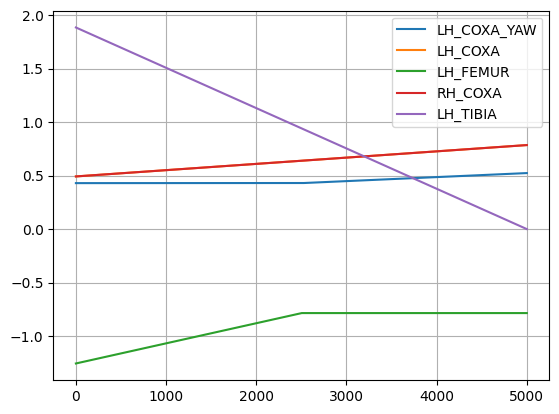

In [201]:
plt.plot(all_joint_angles_abd[:,LH_COXA_YAW], label="LH_COXA_YAW")
plt.plot(all_joint_angles_abd[:,LH_COXA], label="LH_COXA")
plt.plot(all_joint_angles_abd[:,LH_FEMUR], label="LH_FEMUR")
plt.plot(all_joint_angles_abd[:,RH_COXA], label="RH_COXA")
plt.plot(all_joint_angles_abd[:,LH_TIBIA], label="LH_TIBIA")
plt.legend()
plt.grid()

In [202]:
print(all_joint_angles_abd[0,LH_FEMUR], all_joint_angles_abd[-1,LH_FEMUR])

-1.2566370614359172 -0.7853981633974483


##### Simulation

In [203]:
adhesion_action = np.array([0.0 if leg.endswith("H") else 1.0 for leg in legs])

for i in trange(nbre_steps):
    joint_angles = all_joint_angles_abd[i,:]
    action = {'joints': joint_angles, "adhesion": adhesion_action}
    nmf.step(action)
    nmf.render()

nmf.save_video("./outputs/d.mp4")

# if sim_params.render_camera == "Animat/camera_back":
#     nmf.save_video("./outputs/abd_groom_back.mp4")
# elif sim_params.render_camera == "Animat/camera_left":
#     nmf.save_video("./outputs/abd_groom_left.mp4")
# elif sim_params.render_camera == "Animat/camera_right":
#     nmf.save_video("./outputs/abd_groom_right.mp4")
# elif sim_params.render_camera == "Animat/camera_front":    
#     nmf.save_video("./outputs/abd_groom_front.mp4")
# elif sim_params.render_camera == "Animat/camera_top":
#     nmf.save_video("./outputs/abd_groom_top.mp4")
# elif sim_params.render_camera == "Animat/camera_bottom":
#     nmf.save_video("./outputs/abd_groom_bottom.mp4")

last_joint_angles_abd_up = all_joint_angles_abd[-1].copy()

100%|██████████| 5000/5000 [00:41<00:00, 121.91it/s]


In [204]:
# Touch the abdomen + rub it
# put the tibia again at its precedent value
all_joint_angles_abd_groom = np.tile(last_joint_angles_abd_up,(nbre_steps,1)) # shape (nbre_steps, 47)

# all_joint_angles_abd_groom[:,LH_FEMUR] = np.linspace(last_joint_angles_abd_up[LH_FEMUR], start_LH_FEMUR//2, half_nbre_steps)
# all_joint_angles_abd_groom[:,RH_FEMUR] = np.linspace(last_joint_angles_abd_up[RH_FEMUR], start_RH_FEMUR//2, half_nbre_steps)
# all_joint_angles_abd_groom[:,LH_TIBIA] = np.linspace(last_joint_angles_abd_up[LH_TIBIA], np.pi/4, half_nbre_steps)
# all_joint_angles_abd_groom[:,RH_TIBIA] = np.linspace(last_joint_angles_abd_up[RH_TIBIA], np.pi/4, half_nbre_steps)

_lh_coxa_yaw = np.zeros((target_num_steps))
_rh_coxa_yaw = np.zeros((target_num_steps))
_lh_femur_ = np.zeros((target_num_steps))
_rh_femur_ = np.zeros((target_num_steps))
_lh_tibia_ = np.zeros((target_num_steps))
_rh_tibia_ = np.zeros((target_num_steps))

_lh_coxa_yaw[:half_nbre_steps] = np.ones(half_nbre_steps)*(last_joint_angles_abd_up[LH_FEMUR_ROLL])
_lh_coxa_yaw[half_nbre_steps:] = np.linspace(last_joint_angles_abd_up[LH_FEMUR_ROLL], -start_LH_FEMUR_ROLL//2, half_nbre_steps)
_rh_coxa_yaw[:half_nbre_steps] = np.ones(half_nbre_steps)*(last_joint_angles_abd_up[RH_FEMUR_ROLL])
_rh_coxa_yaw[half_nbre_steps:] = np.linspace(last_joint_angles_abd_up[RH_FEMUR_ROLL], start_RH_FEMUR_ROLL//2, half_nbre_steps)

_rh_tibia_[:half_nbre_steps] = np.linspace(last_joint_angles_abd_up[RH_TIBIA], np.pi/6, half_nbre_steps)
_rh_tibia_[half_nbre_steps:] = np.ones(half_nbre_steps)*(np.pi/6)
_lh_tibia_[:half_nbre_steps] = np.linspace(last_joint_angles_abd_up[LH_TIBIA], np.pi/6, half_nbre_steps)
_lh_tibia_[half_nbre_steps:] = np.ones(half_nbre_steps)*(np.pi/6)

_rh_femur_[:half_nbre_steps] = np.linspace(last_joint_angles_abd_up[RH_FEMUR], start_RH_FEMUR//2, half_nbre_steps)
_rh_femur_[half_nbre_steps:] = np.ones(half_nbre_steps)*(start_RH_FEMUR//2)
_lh_femur_[:half_nbre_steps] = np.linspace(last_joint_angles_abd_up[LH_FEMUR], start_LH_FEMUR//2, half_nbre_steps)
_lh_femur_[half_nbre_steps:] = np.ones(half_nbre_steps)*(start_RH_FEMUR//2)


all_joint_angles_abd_groom[:,LH_FEMUR_ROLL] = _lh_coxa_yaw
all_joint_angles_abd_groom[:,RH_FEMUR_ROLL] = _rh_coxa_yaw
all_joint_angles_abd_groom[:,LH_FEMUR] = _lh_femur_
all_joint_angles_abd_groom[:,LH_TIBIA] = _lh_tibia_
all_joint_angles_abd_groom[:,RH_FEMUR] = _rh_femur_
all_joint_angles_abd_groom[:,RH_TIBIA] = _rh_tibia_



-0.2617993877991494 -0.2617993877991494
-0.2617993877991494 -0.2617993877991494


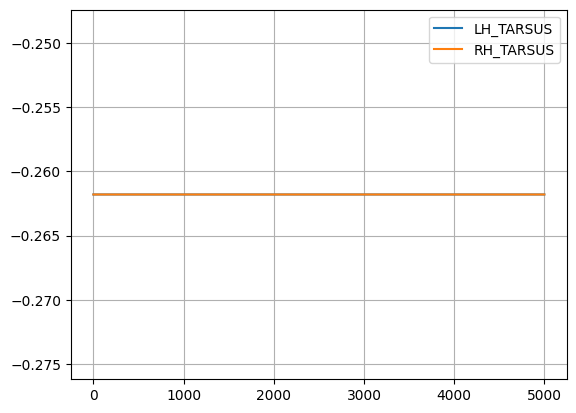

In [205]:
print(all_joint_angles_abd_groom[0,LH_TARSUS], all_joint_angles_abd_groom[-1,LH_TARSUS])
print(start_RH_TARSUS, start_LH_TARSUS)

plt.plot(all_joint_angles_abd_groom[:,LH_TARSUS], label="LH_TARSUS")
plt.plot(all_joint_angles_abd_groom[:,RH_TARSUS], label="RH_TARSUS")
plt.legend()
plt.grid()

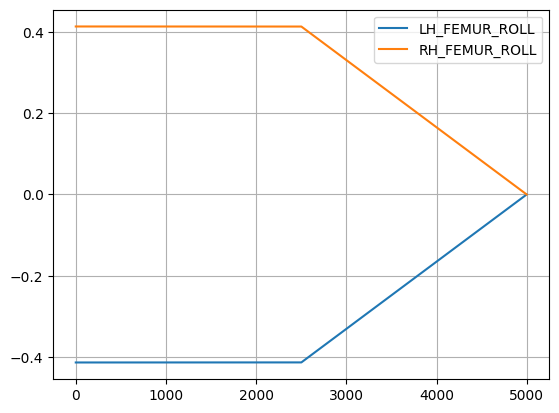

In [206]:
plt.plot(all_joint_angles_abd_groom[:,LH_FEMUR_ROLL], label="LH_FEMUR_ROLL")
plt.plot(all_joint_angles_abd_groom[:,RH_FEMUR_ROLL], label="RH_FEMUR_ROLL")
plt.legend()
plt.grid()

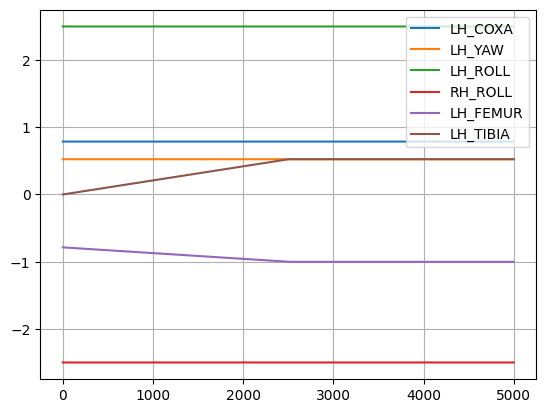

In [207]:
plt.plot(all_joint_angles_abd_groom[:,LH_COXA], label="LH_COXA")
plt.plot(all_joint_angles_abd_groom[:,LH_COXA_YAW], label="LH_YAW")
plt.plot(all_joint_angles_abd_groom[:,LH_COXA_ROLL], label="LH_ROLL")
plt.plot(all_joint_angles_abd_groom[:,RH_COXA_ROLL], label="RH_ROLL")
plt.plot(all_joint_angles_abd_groom[:,LH_FEMUR], label="LH_FEMUR")
plt.plot(all_joint_angles_abd_groom[:,LH_TIBIA], label="LH_TIBIA")
plt.legend()
plt.grid()

In [208]:
adhesion_action = np.array([0.0 if leg.endswith("H") else 1.0 for leg in legs])

for i in trange(nbre_steps):
    joint_angles = all_joint_angles_abd_groom[i,:]
    action = {'joints': joint_angles, "adhesion": adhesion_action}
    nmf.step(action)
    nmf.render()

if sim_params.render_camera == "Animat/camera_back":
    nmf.save_video("./outputs/abd_groom_back.mp4")
elif sim_params.render_camera == "Animat/camera_left":
    nmf.save_video("./outputs/abd_groom_left.mp4")
elif sim_params.render_camera == "Animat/camera_right":
    nmf.save_video("./outputs/abd_groom_right.mp4")
elif sim_params.render_camera == "Animat/camera_front":    
    nmf.save_video("./outputs/abd_groom_front.mp4")
elif sim_params.render_camera == "Animat/camera_top":
    nmf.save_video("./outputs/abd_groom_top.mp4")
elif sim_params.render_camera == "Animat/camera_bottom":
    nmf.save_video("./outputs/abd_groom_bottom.mp4")

last_joint_angles_abd_groom = all_joint_angles_abd_groom[-1].copy()

100%|██████████| 5000/5000 [00:37<00:00, 131.68it/s]


#### Groom abdomen
1. move up un peu l'abdomen
2. check les dernières positions des hindlegs
3. écarter les pattes arrière ---> changer COXA YAW
4. lever les pattes arrière ---> changer FEMUR PITCH
5. abaisser (à plat) la pattes arrière ---> changer FEMUR ROLL
6. 

#### Move the hind legs up

#### Load grooming position of frontleg

In [209]:
# grooming_module_path = Path("./data/grooming_modules_provided_slow.pkl")
# with open(grooming_module_path, "rb") as f:
#     grooming_modules = pickle.load(f)

# timestep_groom = grooming_modules["timestep"]
# target_num_steps_groom = int(1.0 / timestep_groom) # 10'000
# target_joint_angles_front = grooming_modules["foreleg"][:, :target_num_steps]


In [210]:
# # all_joint_angles.shape() = (10000, 42)
# # my all_joint_angles_groom_shape() = (558, 21)

# # need to map the 21 joints to the 42 joints
# target_joint_angles_front = target_joint_angles_front.T # (558, 21)
# target_joint_angles_front = np.tile(target_joint_angles_front, (18, 1)) # (10044, 21)

# joint_LHCoxa = target_joint_angles_front[:,3]

In [211]:
# print(joint_LHCoxa.shape)
# print(joint_LHCoxa[:target_num_steps].shape)
# test = np.ones((target_num_steps, len(all_joint_angles[0])))
# print(test.shape)
# print(target_num_steps)

#### Map the grooming position of the leg to the corresponding body part.

In [212]:
# joint_LHCoxa = target_joint_angles_front[:,3]
# joint_LHCoxa_roll = target_joint_angles_front[:,4]
# joint_LHCoxa_yaw = target_joint_angles_front[:,5]
# joint_LHFemur = target_joint_angles_front[:,6]
# joint_LHFemur_roll = target_joint_angles_front[:,7]
# joint_LHTibia = target_joint_angles_front[:,8]
# joint_LHTarsus = target_joint_angles_front[:,9]
# joint_RHCoxa = target_joint_angles_front[:,10]
# joint_RHCoxa_roll = target_joint_angles_front[:,11]
# joint_RHCoxa_yaw = target_joint_angles_front[:,12]
# joint_RHFemur = target_joint_angles_front[:,13]
# joint_RHFemur_roll = target_joint_angles_front[:,14]
# joint_RHTibia = target_joint_angles_front[:,15]
# joint_RHTarsus = target_joint_angles_front[:,16]


# all_joint_angles = np.ones((target_num_steps, len(all_joint_angles[0]))) # 10000, 42
# print(all_joint_angles.shape)

# all_joint_angles[:,14] = joint_LHCoxa[:target_num_steps] # jusqu'à 10'000
# all_joint_angles[:,15] = joint_LHCoxa_roll[:target_num_steps]
# all_joint_angles[:,16] = joint_LHCoxa_yaw[:target_num_steps]
# all_joint_angles[:,17] = joint_LHFemur[:target_num_steps]
# all_joint_angles[:,18] = joint_LHFemur_roll[:target_num_steps]
# all_joint_angles[:,19] = joint_LHTibia[:target_num_steps]
# all_joint_angles[:,20] = joint_LHTarsus[:target_num_steps]
# all_joint_angles[:,35] = joint_RHCoxa[:target_num_steps]
# all_joint_angles[:,36] = joint_RHCoxa_roll[:target_num_steps]
# all_joint_angles[:,37] = joint_RHCoxa_yaw[:target_num_steps]
# all_joint_angles[:,38] = joint_RHFemur[:target_num_steps]
# all_joint_angles[:,39] = joint_RHFemur_roll[:target_num_steps]
# all_joint_angles[:,40] = joint_RHTibia[:target_num_steps]
# all_joint_angles[:,41] = joint_RHTarsus[:target_num_steps]
